In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import pystan, pickle

from pystan_cache.pystan_cache import caching_stan

# models 

In [6]:
gp_multi_missing = caching_stan.stan_model(file='gp_multi_missing.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9cb5182e980295c4830d52c289d4b0e0 NOW.


In [7]:
gp_multi_sim = caching_stan.stan_model(file='gp_multi_sim.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44c769f3f5eb58c597bb2a84db432353 NOW.


In [4]:
# gp_multi = pystan.StanModel('gp_multi.stan')

# pickle.dump(gp_multi, open('gp_multi.pkl', 'wb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e6066cebf4e932a72beee8ea60e8ffb NOW.


KeyboardInterrupt: 

In [15]:
# gp_multi_missing = pystan.StanModel('gp_multi_missing.stan')

# pickle.dump(gp_multi_missing, open('gp_multi_missing.pkl', 'wb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9cb5182e980295c4830d52c289d4b0e0 NOW.


In [5]:
# gp_multi_sim = pystan.StanModel('gp_multi_sim.stan')
# pickle.dump(gp_multi_sim, open('gp_multi_sim.pkl', 'wb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44c769f3f5eb58c597bb2a84db432353 NOW.


# simulations 

In [8]:
sim_data = {
    'N': 1000,
    'P':3,
    'K':2,
    'length_scale': 0.18,
    'alpha': 1,
    'sigma': .32,
    'design': [[1,1],[1,0],[1,-1]]
}

In [9]:
sample = gp_multi_sim.sampling(algorithm='Fixed_param', iter=1, chains=1, data=sim_data).extract()

In [10]:
sample.keys()

[u'x', u'y', u'f', u'lp__']

In [11]:
x, y, f = sample['x'][0,:], sample['y'][0,:], sample['f'][0,:]

ind = np.argsort(x)

x = x[ind]
y = y[:,ind]
f = f[:,ind]

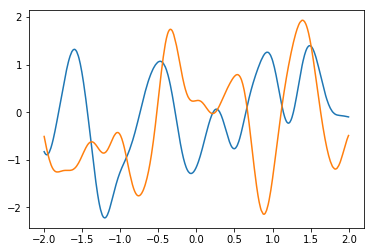

In [12]:
# plt.plot(x,y.T)
plt.plot(x,f.T)

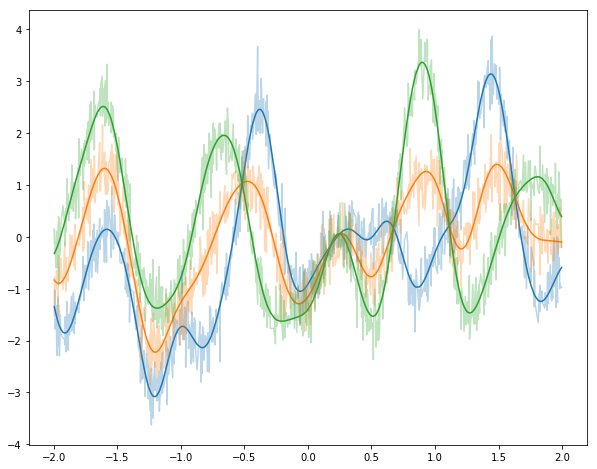

In [13]:
plt.figure(figsize=(10,8))

for i in range(len(sim_data['design'])):
    plt.plot(x,np.dot(sim_data['design'][i],f))
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.plot(x,y[i,:],alpha=.3)

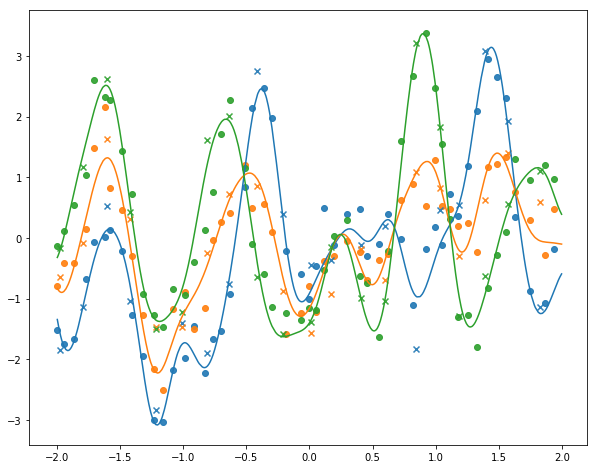

In [44]:
# train_ind = np.random.choice(np.arange(sim_data['N']), size=50, replace=False)
train_ind = np.arange(0,sim_data['N'],20)

# test_ind = [i for i in np.arange(sim_data['N']) if i not in train_ind ]
test_ind = np.arange(5,sim_data['N'],50)

train_ind.sort()
test_ind.sort()

plt.figure(figsize=(10,8))

for i in range(len(sim_data['design'])):
    plt.plot(x,np.dot(sim_data['design'][i],f))
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.scatter(x[train_ind],y[i,train_ind],alpha=.9)
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.scatter(x[test_ind],y[i,test_ind],alpha=.9, marker='x')
    
# plt.scatter(x[test_ind], y[:,test_ind]);
# plt.scatter(x[train_ind], y[:,train_ind],s=100);
# plt.plot(x,f, c='k', lw=3);

In [20]:
train_data = sim_data.copy()
train_data['N'] = len(train_ind)
train_data['y'] = y[:,train_ind]
train_data['x'] = x[train_ind]

In [23]:
tsamples = gp_multi.sampling(data=train_data, chains=4, iter=2000, control = {'adapt_delta': 0.95})

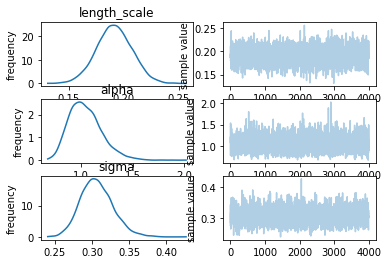

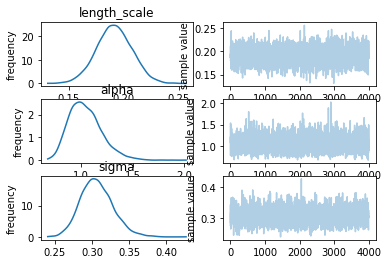

In [35]:
tsamples.plot(['length_scale', 'alpha', 'sigma'])

In [36]:
tsamp = tsamples.extract(permuted=True)

In [37]:
tsamp['f'].shape

(4000, 2, 50)

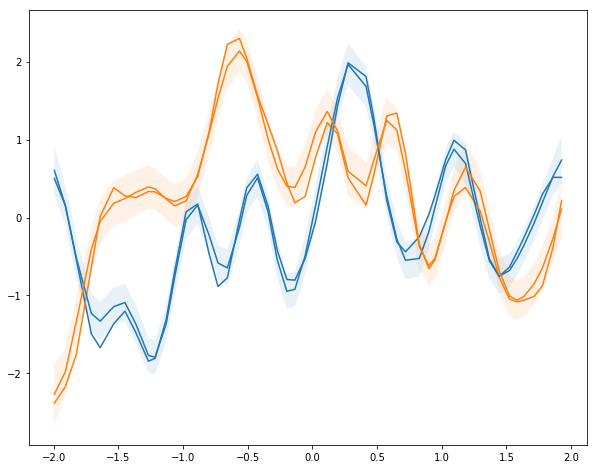

In [38]:
plt.figure(figsize=(10,8))

plt.plot(x[train_ind],f[:,train_ind].T)

plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.plot(x[train_ind], tsamp['f'][:,i,:].mean(0))
    
plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.fill_between(x[train_ind], 
                     tsamp['f'][:,i,:].mean(0)-2*tsamp['f'][:,i,:].std(0),
                     tsamp['f'][:,i,:].mean(0)+2*tsamp['f'][:,i,:].std(0),alpha=.1)

In [16]:
# test with no missing data

train_data = sim_data.copy()
train_data['N'] = len(train_ind)
train_data['y'] = y[:,train_ind]
train_data['x'] = x[train_ind]

train_data['N_mis'] = 0
train_data['x_mis'] = []

tsamples = gp_multi_missing.sampling(data=train_data, chains=4, iter=2000, control = {'adapt_delta': 0.95})

In [17]:
tsamp = tsamples.extract(permuted=True)

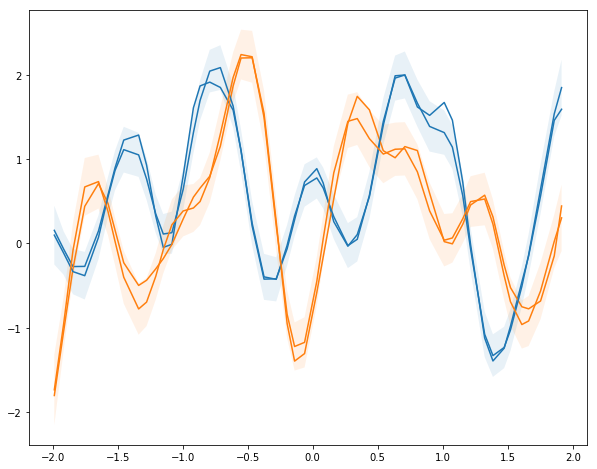

In [18]:
plt.figure(figsize=(10,8))

plt.plot(x[train_ind],f[:,train_ind].T)

plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.plot(x[train_ind], tsamp['f'][:,i,:].mean(0))
    
plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.fill_between(x[train_ind], 
                     tsamp['f'][:,i,:].mean(0)-2*tsamp['f'][:,i,:].std(0),
                     tsamp['f'][:,i,:].mean(0)+2*tsamp['f'][:,i,:].std(0),alpha=.1)

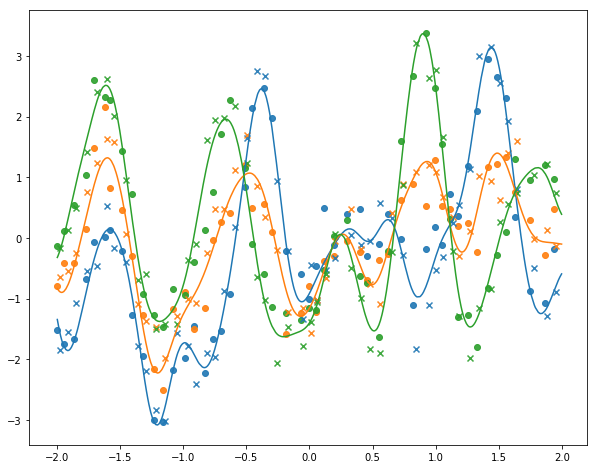

In [51]:
# train_ind = np.random.choice(np.arange(sim_data['N']), size=50, replace=False)
train_ind = np.arange(0,sim_data['N'],20)

# test_ind = [i for i in np.arange(sim_data['N']) if i not in train_ind ]
test_ind = np.arange(5,sim_data['N'],20)

train_ind.sort()
test_ind.sort()

plt.figure(figsize=(10,8))

for i in range(len(sim_data['design'])):
    plt.plot(x,np.dot(sim_data['design'][i],f))
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.scatter(x[train_ind],y[i,train_ind],alpha=.9)
    
plt.gca().set_prop_cycle(None)
    
for i in range(len(sim_data['design'])):
    plt.scatter(x[test_ind],y[i,test_ind],alpha=.9, marker='x')

In [52]:
train_data = sim_data.copy()
train_data['N'] = len(train_ind)
train_data['y'] = y[:,train_ind]
train_data['x'] = x[train_ind]

train_data['N_mis'] = len(test_ind)
train_data['x_mis'] = x[test_ind]

train_data['N_mis']

50

In [53]:
tsamples = gp_multi_missing.sampling(data=train_data, chains=4, iter=2000, control = {'adapt_delta': 0.95})

In [54]:
tsamp = tsamples.extract(permuted=True)

In [55]:
tsamp.keys()

[u'length_scale',
 u'alpha',
 u'sigma',
 u'f_eta',
 u'y_mis',
 u'f',
 u'y_tot',
 u'lp__']

In [56]:
all_ind = np.array(train_ind.tolist() + test_ind.tolist())

sort = np.argsort(all_ind)

all_ind = all_ind[sort]

# np.argsort(all_ind)
all_ind

array([  0,   5,  20,  25,  40,  45,  60,  65,  80,  85, 100, 105, 120,
       125, 140, 145, 160, 165, 180, 185, 200, 205, 220, 225, 240, 245,
       260, 265, 280, 285, 300, 305, 320, 325, 340, 345, 360, 365, 380,
       385, 400, 405, 420, 425, 440, 445, 460, 465, 480, 485, 500, 505,
       520, 525, 540, 545, 560, 565, 580, 585, 600, 605, 620, 625, 640,
       645, 660, 665, 680, 685, 700, 705, 720, 725, 740, 745, 760, 765,
       780, 785, 800, 805, 820, 825, 840, 845, 860, 865, 880, 885, 900,
       905, 920, 925, 940, 945, 960, 965, 980, 985])

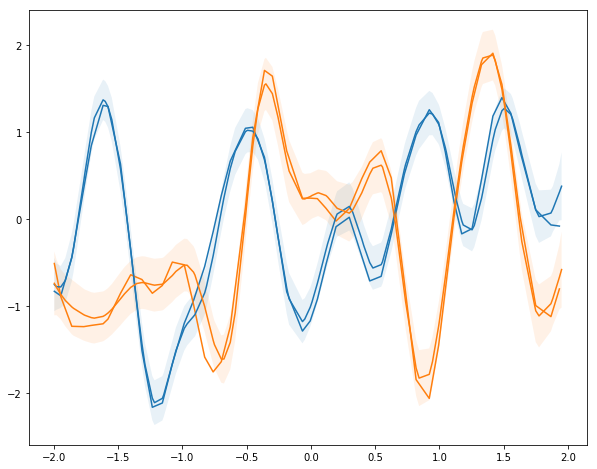

In [57]:
plt.figure(figsize=(10,8))

plt.plot(x[train_ind],f[:,train_ind].T)

plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.plot(x[all_ind], tsamp['f'][:,i,sort].mean(0))
    
plt.gca().set_prop_cycle(None)

for i in range(f.shape[0]):
    plt.fill_between(x[all_ind], 
                     tsamp['f'][:,i,sort].mean(0)-2*tsamp['f'][:,i,sort].std(0),
                     tsamp['f'][:,i,sort].mean(0)+2*tsamp['f'][:,i,sort].std(0),alpha=.1)